In [1]:
%matplotlib notebook
from fringe_tracing import *
from skimage.filters import gaussian

#### Set folder containing Interferograms
On Windows, you can shift+right-click a folder and choose "Copy as Path"

In [2]:
%cd "C:\Users\jdhare\Google Drive\MAGPIE\data\2017\s0921_17 C reconnection Faraday"

C:\Users\jdhare\Google Drive\MAGPIE\data\2017\s0921_17 C reconnection Faraday


#### Load the background interferogram
We start with the background because it gives us good default values for the shot interferogram. Copy the file name into interferogram_path. The next two lines load the interferogram and convert it to grayscale

In [3]:
interferogram_path="s0921_17 532nm end on Interferometry (3).JPG"
interferogram=imread(interferogram_path)
interferogram=rgb2gray(interferogram)

#### Normalise the interferogram
We correct for variations in brightness by dividing the interferogram by a blurred version of itself. Choose a the smallest value for blur such that no fringes are visible - it will be around the width of two fringes in pixels.

<IPython.core.display.Javascript object>


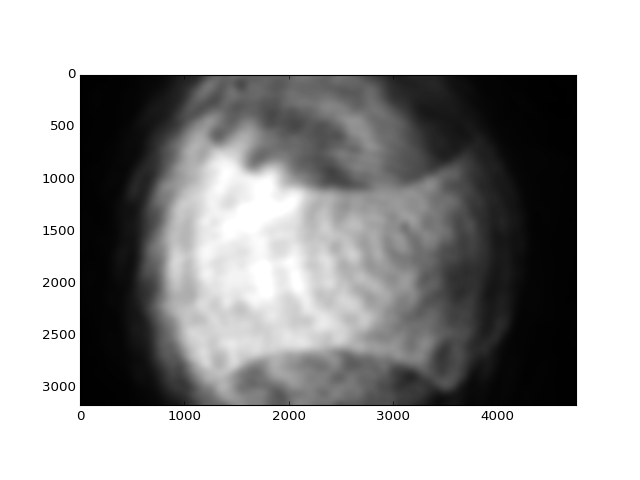

In [4]:
blur=40
blurred_interferogram=gaussian(interferogram, blur)
normalised_interferogram=interferogram/blurred_interferogram

fig, ax=plt.subplots(figsize=(8,6))
ax.imshow(blurred_interferogram, cmap='gray', clim=[0,0.5])

#### Check the Fourier image
Once you're happy with the blurred interferogram, check out the Fourier transform of the noramlised interferogram. Zoom in on the centre of the image - there should be two blobs on opposite sides of the centre. These contain the information about the predominant fringe pattern, and we'll get rid of all the other data.

In [5]:
fftim=(np.fft.fftshift(np.fft.fft2(normalised_interferogram)))
fig, ax=plt.subplots(figsize=(8,6))
ax.imshow(abs(fftim), cmap='plasma', clim=[0,100000])

<IPython.core.display.Javascript object>

#### Select a region from the Fourier image
Use the sliders below to select the important parts of the Fourier image. The mask consists of two circles at a distance R_0 from the centre, at an angle of theta to the vertical. Each circle has a radius of 'Radius of filter' and the edges can be smoothed slightly with 'Filter blur' to prevent hard edges causes artefacts after the inverse Fourier transform happens.

In general, you want the smallest circles that are centered on the two bright spots in the Fourier image, with a little blur (eg. 20% of the filter radius).

In [6]:
w1=interactive(plot_filter, 
               fft=fixed(fftim), R0=R0, theta=theta, 
               radius_of_filter=radius_of_filter, blur=blur_edges)
display(w1)

<IPython.core.display.Javascript object>

#### Create Fourier-filtered Interferogram
Once you're happy with the region of Fourier space you're keeping in the above cell, it's time to do the inverse Fourier transform and look at the resulting interferogram.
This interferogram will only contain fringes aligned with the predominant fringe pattern, and it doesn't include the high frequeny modulations seen in the beam,

In [7]:
a,fft_filter=create_filter(**w1.kwargs)
masked_fft=fft_filter*fftim
ifftim=abs((np.fft.ifft2(masked_fft)))
fig, ax=plt.subplots(figsize=(8,6))
ax.imshow(ifftim, cmap='gray', clim=[0,0.5])

<IPython.core.display.Javascript object>

#### Threshold the image
Now we need to conver this interferogram to a binary black or white image. Then an algorithm reduces these black and white fringes to one pixel thick lines for MAGIC.

First, change a threshold so it is approximately the value halfway between a dark and a bright fringe - something like 0.1-0.3 usually works. Then run the cell. A PNG file will be created in whichever folder the original interferogram was in, with the same file name + 'traced'.

Open the traced interferogram and inspect it. If the fringes don't extend as far as you'd like, then decrease the threshold value. If the fringes are joined by short perpendicular fringes, increase the threshold value. Keep editing threshold value and running this cell until you're happy with the result.

In [8]:
threshold_value=0.3

bwimage=ifftim>threshold_value
imthin=thin(bwimage, max_iter=1000)
invert=1-imthin
save_fn=os.path.splitext(interferogram_path)[0]+' traced.png'
imsave(save_fn, invert*255)

#### Auto-tracing the shot interferogram
Go back to the top, and edit the filename so it points to the shot interferogram. Work through all the cells in order. When you get to choosing the region of interest in the Fourier image, the values you used for the background interferogram will be loaded as the initial region. 

Now you might want to expand the radius of the circles to include more of the Fourier image, as fringes which are slightly bent will be in a region nearby to initial region. Do the inverse Fourier transform, check that most of the fringes are still present, and then threshold and save out the image - experiment with a different threshold value to maximise the number of auto-traced fringes.

#### How to use these images in photoshop
1. Open one of the raw interferograms in Photoshop.
2. File>Place the other raw interferogram and the two traced interferograms as layers
3. Layer>Rasterize all layers
4. Use the 'magic eraser' to remove the white background on the two traced interferograms
5. Layer>Layer style>Colour overlay choose a contrasting colour so traced fringes show up on bright and dark regions of interferogram
6. Use the eraser to remove fringes that have been traced wrongly
7. Create a mask using the pen tool in the standard way
8. Draw new fringes using the pen tool, stroke with a 1 px black pencil onto the appropriate traced interferogram layer
9. Place a white layer beneath the traced interferogram layer.
10. Use the threhold adjustment layer tool to ensure the lines are black (threshold 255)
11. Save as PNG and load with MAGIC.